## This is my attempt at implementing the SLANG algorithm

importing

In [5]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.linalg as alg
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
#from tqdm import tqdm

EPS = 1e-5  # define a small constant for numerical stability control

### Class defined

In [ ]:
class SLANG_GaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, inital_prior_std = 0.1, inital_prior_mean = 0.0, alpha = 0.9, beta = 0.9,
                 sqrt_width_scaling=False, device=None, dtype=None, minibatch_size = 1, error = 1e-12, rank_approx = 4, noise = 1):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(SLANG_GaussianNetwork, self).__init__()

        # Store network dimensions and other parameters
        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0] 
        self.dim_out = layer_sizes[-1]
        self.num_params = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:])) # number of parameters

        self.alpha = alpha
        self.beta = beta
        self.minibatch_size = minibatch_size 
        self.error = error
        self.rank_approx = rank_approx
        self.noise = noise
        # prior parameters are registered as buffers so they can be alteared  
        self.register_buffer('prior_means', torch.ones(self.num_params, **factory_kwargs)*inital_prior_mean)

        # prior covariance matrix
        prior_cov = torch.diag(torch.ones(self.num_params, **factory_kwargs)*inital_prior_std)
        # prior variance scales as 1/dim_in
        if sqrt_width_scaling:  
            prior_cov /= self.dim_in ** 0.5
        self.register_buffer('prior_cov', prior_cov)

        self.prior_mean = inital_prior_mean
        self.prior_std = inital_prior_std 
    
    def ___dia_inv___(self, D):
        '''the inveres of a 2D diagonal matrix'''
        d = torch.zeros(self.num_params, self.num_params)
        for i in range(self.num_params):
            d[i,i] = 1/D[i,i]
        return d


    def ___fast_inverse___(self, g, U, D, L):
        D_inv = self.___dia_inv___(D) # D^{-1}
        I_L = torch.eye(L) # I size L
        U_Td_invU = torch.t(U) @ D_inv @ U # U^T.D^{-1}.U
        A = alg.inv(I_L + U_Td_invU) # A = (I_L + U^T.D^{-1}.U)^{-1}

        UAU_T = U @ A @ torch.t(U) # U.A.U^T
        D_inv_g = D_inv @ g # D^{-1}.g
        y = D_inv_g - D_inv @ UAU_T @ D_inv_g  # D^{-1}.g - D^{-1}.U^T.A.U.D^{-1}.g

        return y



    def ___fast_sample___(self, mean, U, D, L):
        eps = torch.normal(0,1,size = (self.num_params, 1))
        Dinv = self.___dia_inv___(D)
        Dinv_x = Dinv @ eps
        I_UDU = alg.inv(torch.eye(L) + torch.t(U) @ Dinv @ U)
        UDinv_x = torch.t(U) @ Dinv_x
        y = Dinv_x - Dinv @ U @ I_UDU @ UDinv_x
        return mean + torch.squeeze(y)

    def ___minibatch___(self, M, data):
        n = data.size(dim=1)
        p = torch.ones(n)/n
        index = p.multinomial(num_samples=M)
        return data[index]


    def ___conditional___(self, D, U, D_p, U_p):
        current_approx = D + U @ torch.t(U)
        pevious_approx = D_p + U_p @ torch.t(U_p)
        return alg.matrix_norm(current_approx - pevious_approx) < self.error

    def SLANG(self, data):
        # Initializing
        L = self.rank_approx
        mean = self.prior_means
        U = torch.zeros((self.num_params, L), requires_grad=True)
        D = torch.diag(torch.ones(self.num_params, requires_grad=True)*self.prior_std)

        # previous U and D
        U_p = torch.zeros((self.num_params, L), requires_grad=True) 
        D_p = torch.zeros((self.num_params, self.num_params), requires_grad=True)

        lamb = 1/self.prior_std
        beta = self.beta
        delta = 1 - beta
        M = self.minibatch_size
        N = data.shape[0]
        counter = 0 
        while counter < 2:

            if self.___conditional___(D, U, D_p, U_p):
                counter += 1 
            else:
                counter = 0
            
            # generatind a sample from  θ_t ∼ N (θ|µ_t, U_tU_t^T + D_t).
            theta = self.___fast_sample___(mean, U, D, L)

            # sample a minibatch
            data_M = self.___minibatch___(M, data)

            # backprop
            g = self.___backprop_goodfellow___(M, data_M, theta) #, D + U @ torch.t(U), mean_p, D_p + U_p @ torch.t(U_p))

            # getting the the matrix Q_{1:L}\Lamda_{1:L}^{1/2}
            G_hat = N/M*g @ torch.t(g)
            A = delta*(U @ torch.t(U)) + beta*G_hat # are approximation is herman 
            V = self.___fast_eig___(A, L) 

            grad_d = delta * (U**2).sum(dim=1) + beta * (g**2).sum(dim=1) - (V**2).sum(dim=1)

            # updating U and D
            U_p = U 
            D_p = D
            
            U = V
            D = torch.diag(delta*torch.diagonal(D) + grad_d + lamb)

            # caculating 
            
            g_hat = sum(g) + lamb*mean
            grad_mean = self.___fast_inverse___(g_hat, U, D, L)
            mean = mean - self.alpha*grad_mean
            print(U @ torch.t(U) + D)
            

        return mean, U, D

    def ___Q_from_qr___(self, A):
        Q, _ = alg.qr(A)
        return Q

    def ___nystrom___(self, U, Q, anorm):
        """
        Use the Nystrom method to obtain approximations to the
        eigenvalues and eigenvectors of A (shifting A on the subspace
        spanned by the columns of Q in order to make the shifted A be
        positive definite).
        """
        
        def ___svd_thin_matrix___(A):
            """
            Efficient implementation of SVD on [N x D] matrix, D >> N.
            """
            (e, V) = alg.eigh(A @ A.t())
            
            Sigma = torch.sqrt(e)
            SigInv = 1/Sigma 
            SigInv[torch.isnan(SigInv)] = 0
            U = A.t() @ (V * SigInv)
            
            return U, Sigma, V
            
        anorm = .1e-6 * anorm * math.sqrt(1. * self.num_params)
        E = U @ Q + anorm * Q
        R = Q.t() @ E
        R = (R + R.t()) / 2
        R = alg.cholesky(R, upper=False) # Cholesky
        tmp = alg.solve(R, E.t()) # Solve
        V, d, _ = ___svd_thin_matrix___(tmp)
        d = d * d - anorm
        return d, V

    # Alot of this this copped 
    def ___fast_eig___(self, A, L, n_iter = 8): # ?
        # From Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositi page 35 see usefull reading
        # and based on the Github https://github.com/aaronpmishkin/SLANG 
        K = L + 2
        Q = 2*(torch.rand((self.num_params, K), device= A.device, dtype= A.dtype)-0.5)
        for _ in range(max(0, n_iter-1)):
            Q = self.___Q_from_qr___(A @ Q)
        
        oldQ = Q
        
        Q = A @ Q
        anorm = torch.max(torch.norm(Q, dim=0)/torch.norm(oldQ, dim=0))
        Q = self.___Q_from_qr___(Q)
        
        d, V = self.___nystrom___(A, Q, anorm)

        # Retain only the entries with the k greatest absolute values
        _, idx = torch.abs(d).sort()
        idx = idx[:L]
        return V[:, idx] @ torch.diag(abs(d[idx])**0.5)

    
    def ___forward___(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input 
    
    '''
    def loss(mean, cov, mean_p, cov_p):
        """ Computes and returns the KL divergence KL(q||p), where:
            q is the variational distribution; and
            p is the prior distribution
        """
        q = dist.MultivariateNormal(mean, scale_tril = cov)
        p = dist.MultivariateNormal(mean_p, scale_tril = cov_p)
        kl = dist.kl_divergence(q, p).sum()
        return kl'''
    
    
    def ___backprop_goodfellow___(self, M, data_M, theta):#, cov, mean_p, cov_p):
        theta.retain_grad()
        g = torch.zeros((M, self.num_params))
        for i in range(M):
            # forward pass
            pred = self.___forward___(data_M[i, :1], theta)
            # backward pass with the log likelihood i.e. logp(Di|θt)
            pred.backward(-1/(self.noise**2) * (data_M[i, 1:] - pred), retain_graph=True)
            g[i] += theta.grad
            theta.grad.zero_() # zero the gradients for the next sample
            
        return g
    
net = SLANG_GaussianNetwork([1, 2, 1], inital_prior_std=0.1)
data = torch.tensor(([1.0, 2.0], [1.5, 3.1], [1.01, 2.0]), requires_grad=True)


# Compute the cov wrt the sampled network parameters
#mean, U, D = net.SLANG(data)

### Testing

In [14]:
# Example usage
net = SLANG_GaussianNetwork([1, 2, 1], inital_prior_std=0.001, alpha = 0.1, beta = 0.9, rank_approx = 5)
data = torch.tensor(([1.0, 2.0], [1.5, 3.1], [1.01, 2.0]), requires_grad=True)


# Compute the cov wrt the sampled network parameters
mean, U, D = net.SLANG(data)

tensor([[8.4655e+17, 2.5397e+18, 2.5397e+18, 2.5397e+18, 2.5397e+18, 2.5397e+18,
         2.5397e+18],
        [2.5397e+18, 8.4655e+17, 2.5397e+18, 2.5397e+18, 2.5397e+18, 2.5397e+18,
         2.5397e+18],
        [2.5397e+18, 2.5397e+18, 8.4655e+17, 2.5397e+18, 2.5397e+18, 2.5397e+18,
         2.5397e+18],
        [2.5397e+18, 2.5397e+18, 2.5397e+18, 8.4655e+17, 2.5397e+18, 2.5397e+18,
         2.5397e+18],
        [2.5397e+18, 2.5397e+18, 2.5397e+18, 2.5397e+18, 8.4655e+17, 2.5397e+18,
         2.5397e+18],
        [2.5397e+18, 2.5397e+18, 2.5397e+18, 2.5397e+18, 2.5397e+18, 8.4655e+17,
         2.5397e+18],
        [2.5397e+18, 2.5397e+18, 2.5397e+18, 2.5397e+18, 2.5397e+18, 2.5397e+18,
         8.4655e+17]], grad_fn=<AddBackward0>)
tensor([[8.4655e+16, 2.5397e+17, 2.5397e+17, 2.5397e+17, 2.5397e+17, 2.5397e+17,
         2.5397e+17],
        [2.5397e+17, 8.4655e+16, 2.5397e+17, 2.5397e+17, 2.5397e+17, 2.5397e+17,
         2.5397e+17],
        [2.5397e+17, 2.5397e+17, 8.4655e+16, 2.5

KeyboardInterrupt: 

In [ ]:
def ___Q_from_qr___( A):
        Q, _ = alg.qr(A)
        return Q

def ___nystrom___(U, Q, anorm):
    """
    Use the Nystrom method to obtain approximations to the
    eigenvalues and eigenvectors of A (shifting A on the subspace
    spanned by the columns of Q in order to make the shifted A be
    positive definite).
    """
    
    def ___svd_thin_matrix___(A):
        """
        Efficient implementation of SVD on [N x D] matrix, D >> N.
        """
        (e, V) = alg.eigh(A @ A.t())
        
        Sigma = torch.sqrt(e)
        SigInv = 1/Sigma 
        SigInv[torch.isnan(SigInv)] = 0
        U = A.t() @ (V * SigInv)
        
        return U, Sigma, V
        
    anorm = .1e-6 * anorm * math.sqrt(1. * num_params)
    E = U @ Q + anorm * Q
    R = Q.t() @ E
    R = (R + R.t()) / 2
    R = alg.cholesky(R, upper=False) # Cholesky
    tmp = alg.solve(R, E.t()) # Solve
    V, d, _ = ___svd_thin_matrix___(tmp)
    d = d * d - anorm
    return d, V

# Alot of this this copped 
def ___fast_eig___(self, A, L, n_iter = 8): # ?
    # From Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositi page 35 see usefull reading
    # and based on the Github https://github.com/aaronpmishkin/SLANG 
    K = L + 2
    Q = 2*(torch.rand((self.num_params, L), device= A.device, dtype= A.dtype)-0.5)
    for _ in range(max(0, n_iter-1)):
        Q = self.___Q_from_qr___(A @ Q)
    
    oldQ = Q
    
    Q = A @ Q
    anorm = torch.max(torch.norm(Q, dim=0)/torch.norm(oldQ, dim=0))
    Q = self.___Q_from_qr___(Q)
    
    d, V = self.___nystrom___(A, Q, anorm)

    # Retain only the entries with the k greatest absolute values
    _, idx = torch.abs(d).sort()
    idx = idx[:L]
    return V[:, idx] @ torch.diag(abs(d[idx])**0.5)

### Regression Ground Truth & Dataset

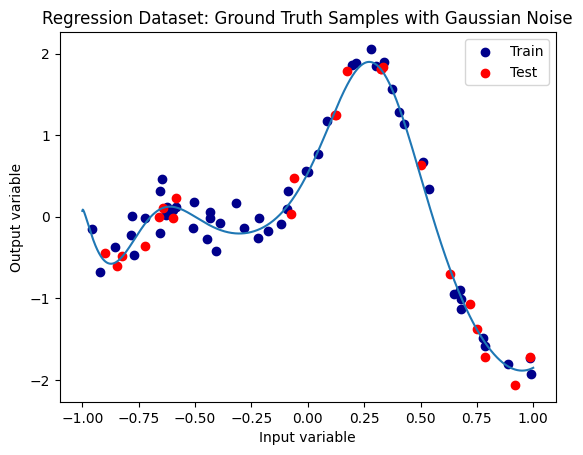

torch.Size([52, 1])

In [ ]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=75, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

y_tr.shape

### Training

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 2

net = SLANG_GaussianNetwork([1, 50, 1], inital_prior_std=0.1)

sampled_params = net.sample_params()
net.forward(x_tr, sampled_params)


# for epoch in tqdm(range(n_epochs)):
    

AttributeError: 'FullCovGaussianNetwork' object has no attribute 'sample_params'